### Prediction Model

Data has been already cleaned in SQL.

A database with a timestamp every 5 min was created with the station and weather data.
The day-time savings time change was adjusted.
A column for the day was added.
The status for the night was corrected to closed.
The CSV clean_db.csv was created from that. This database will be used as test and validation set for this prediction model.
Column with just time.

For the prediction model there will be a random forest regression done for each station.

In [1]:
# Import the required packages
# Import package pandas for data analysis
import pandas as pd

# Import package numpy for numeric computing
import numpy as np

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt

# Imports for random forest regression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# For showing plots directly in the notebook run the command below
%matplotlib inline

# Connect DB
import sys
sys.path.append('../web/')
from dbConnection import get_clean_db

In [46]:
# Reading from a csv file, into a data frame
df = pd.read_csv("C:/Users/colen/Documents/GitHub/clean_db.csv", keep_default_na=True, dtype={16: str}, delimiter=',', skipinitialspace=True, encoding='Windows-1252') #sep=',\s+',

In [7]:
#sql_query = get_clean_db()
#df = pd.DataFrame(sql_query, columns = ['timestamp', 'station_id', 'available_bikes', 'available_bike_stands', 'status', 'temperature', 'pressure', 'humidity', 'clouds', 'wind_speed_beaufort', 'wind_direction', 'precipitation_value', 'precipitation_min', 'precipitation_max', 'precipitation_probability', 'wind_speed_mps', 'weather_type', 'icon_number', 'temperature_feels_like', 'day_flag', 'time', 'day'])

In [47]:
print("Rows: " + str(df.shape[0]))
print("Columns: " + str(df.shape[1]))
print(df.columns)
df.dtypes

Rows: 989972
Columns: 22
Index(['timestamp', 'station_id', 'available_bikes', 'available_bike_stands',
       'status', 'temperature', 'pressure', 'humidity', 'clouds',
       'wind_speed_beaufort', 'wind_direction', 'precipitation_value',
       'precipitation_min', 'precipitation_max', 'precipitation_probability',
       'wind_speed_mps', 'weather_type', 'icon_number',
       'temperature_feels_like', 'day_flag', 'time', 'day'],
      dtype='object')


timestamp                     object
station_id                     int64
available_bikes                int64
available_bike_stands          int64
status                        object
temperature                  float64
pressure                     float64
humidity                     float64
clouds                       float64
wind_speed_beaufort            int64
wind_direction               float64
precipitation_value          float64
precipitation_min            float64
precipitation_max            float64
precipitation_probability    float64
wind_speed_mps               float64
weather_type                  object
icon_number                  float64
temperature_feels_like       float64
day_flag                       int64
time                          object
day                           object
dtype: object

### Time Changes

In [48]:
# Type changes & drops
df.drop(['timestamp', 'weather_type', 'icon_number'], axis=1, inplace=True)

In [49]:
df["time"] = pd.to_datetime(df["time"], format="%H:%M:%S")
df["time"] = df["time"].dt.strftime("%H:%M:%S")

In [50]:
def to_category(column):
    list_unique = []
    for i in sorted(df[column].unique()):
        list_unique.append(i)

    list_range = [i for i in range(len(list_unique))]
    df[column] = df[column].astype('category')
    df[column].cat.add_categories(list_range, inplace=True)

    df[column] = df[column].replace(list_unique, list_range)
    df[column] = df[column].astype('int64')

In [51]:
to_category("status")
to_category("time")
to_category("day")

C:\Users\colen\AppData\Local\Temp\ipykernel_12416\2460517589.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[column].cat.add_categories(list_range, inplace=True)
C:\Users\colen\AppData\Local\Temp\ipykernel_12416\2460517589.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[column].cat.add_categories(list_range, inplace=True)
C:\Users\colen\AppData\Local\Temp\ipykernel_12416\2460517589.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[column].cat.add_categories(list_range, inplace=True)


In [56]:
print(df["status"].ravel())
print(df["time"].ravel())
print(df["day"].ravel())
print(df.dtypes)

[1 1 1 ... 1 1 1]
[127 127 127 ... 108 108 108]
[0 0 0 ... 4 4 4]
station_id                     int64
available_bikes                int64
available_bike_stands          int64
status                         int64
temperature                  float64
pressure                     float64
humidity                     float64
clouds                       float64
wind_speed_beaufort            int64
wind_direction               float64
precipitation_value          float64
precipitation_min            float64
precipitation_max            float64
precipitation_probability    float64
wind_speed_mps               float64
temperature_feels_like       float64
day_flag                       int64
time                           int64
day                            int64
dtype: object


C:\Users\colen\AppData\Local\Temp\ipykernel_12416\1135637488.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'station_id'),
  Text(1.5, 0, 'available_bikes'),
  Text(2.5, 0, 'available_bike_stands'),
  Text(3.5, 0, 'status'),
  Text(4.5, 0, 'temperature'),
  Text(5.5, 0, 'pressure'),
  Text(6.5, 0, 'humidity'),
  Text(7.5, 0, 'clouds'),
  Text(8.5, 0, 'wind_speed_beaufort'),
  Text(9.5, 0, 'wind_direction'),
  Text(10.5, 0, 'precipitation_value'),
  Text(11.5, 0, 'precipitation_min'),
  Text(12.5, 0, 'precipitation_max'),
  Text(13.5, 0, 'precipitation_probability'),
  Text(14.5, 0, 'wind_speed_mps'),
  Text(15.5, 0, 'temperature_feels_like'),
  Text(16.5, 0, 'day_flag'),
  Text(17.5, 0, 'time'),
  Text(18.5, 0, 'day')])

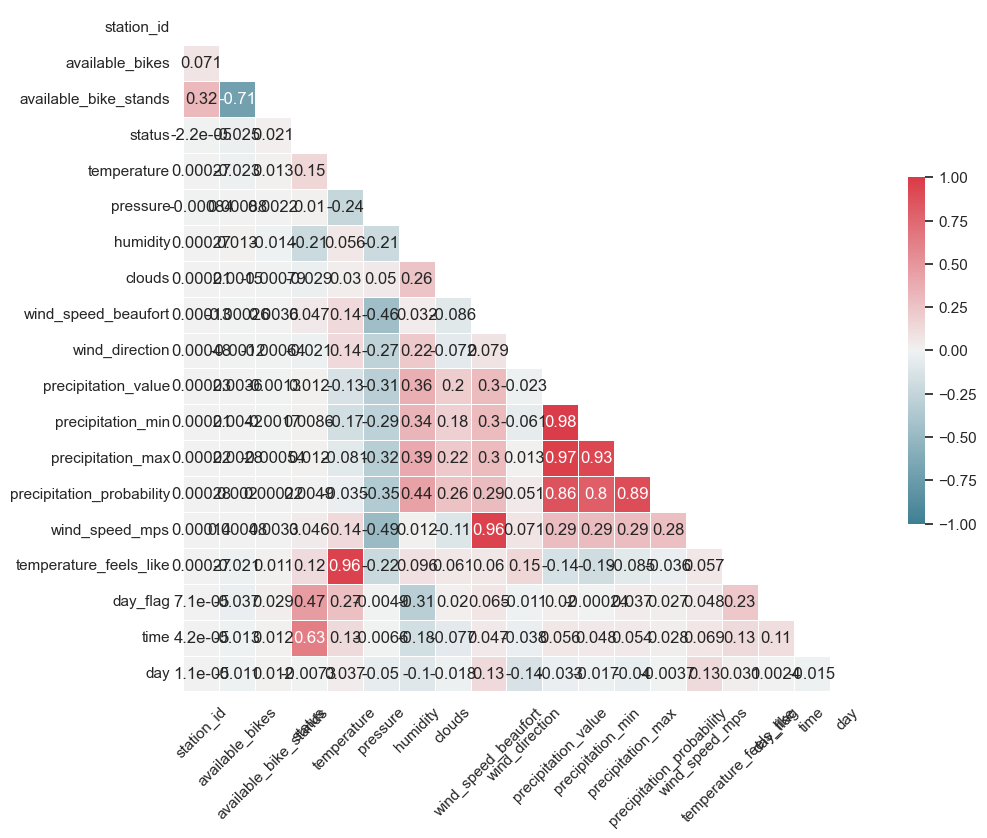

In [57]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
station_id,989972.0,58.801653,34.137513,1.00,29.00,58.00,89.00,117.00
available_bikes,989972.0,11.684631,9.539919,0.00,4.00,10.00,18.00,40.00
available_bike_stands,989972.0,19.956977,10.960674,0.00,12.00,20.00,29.00,40.00
status,989972.0,0.823848,0.380950,0.00,1.00,1.00,1.00,1.00
temperature,989972.0,8.042274,3.230907,0.70,6.00,7.90,10.70,15.20
pressure,989972.0,1009.651882,15.903035,977.20,996.30,1007.80,1024.00,1039.40
humidity,989972.0,76.065314,11.225692,30.70,69.70,77.70,84.70,97.30
clouds,989972.0,80.391374,32.156444,0.00,74.90,99.70,100.00,100.00
wind_speed_beaufort,989972.0,2.858215,1.051953,0.00,2.00,3.00,3.00,6.00
wind_direction,989972.0,177.846502,92.320781,0.00,86.60,201.40,249.80,358.60


In [60]:
df.isnull().sum()

station_id                   0
available_bikes              0
available_bike_stands        0
status                       0
temperature                  0
pressure                     0
humidity                     0
clouds                       0
wind_speed_beaufort          0
wind_direction               0
precipitation_value          0
precipitation_min            0
precipitation_max            0
precipitation_probability    0
wind_speed_mps               0
temperature_feels_like       0
day_flag                     0
time                         0
day                          0
dtype: int64

## Random Forest Experiments

In [ ]:
X = df.drop(['timestamp', 'weather_type', 'icon_number', 'status', 'time', 'day', 'available_bikes', 'available_bike_stands'],axis=1)
y = df['available_bikes']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((205943, 14), (88262, 14))

In [ ]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [ ]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 44 s, sys: 1.33 s, total: 45.3 s
Wall time: 14.7 s


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
# checking the oob score
classifier_rf.oob_score_

0.08778608329244711

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [ ]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


/Users/florian/opt/anaconda3/envs/comp30830/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
grid_search.best_score_

In [ ]:
rf_best = grid_search.best_estimator_
rf_best